# Confidence guided informative path planning

This notebook runs experiments with variations of confidence guided IPP. It considers a __one day__ experiment on a __static environment__ with a __single robot__. 

Confidence guided path planning algorithms query the estimator (or a simplified estimator) during the trajectory, and change the path based on the estimator's return values. 

In [1]:
# allow imports from the main source directory
import sys
sys.path.append('..')
import logging
logging.basicConfig(level=logging.WARNING)

import pathlib
import itertools
import pickle
import gzip as compress
import copy
import matplotlib.pyplot as plt
import matplotlib.lines as lines
import matplotlib.patches as patches
# configuring the fonts such that no Type 3 fonts are used
# requirement for ICRA
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams["figure.autolayout"] = True

import numpy as np
# import timeit
import warnings

from InformationModel import StoredObservationIM
from WaterberryFarm import create_wbfe, WaterberryFarm, MiniberryFarm, WBF_IM_DiskEstimator, WBF_IM_GaussianProcess, WBF_Score_WeightedAsymmetric, WBF_MultiScore, get_datadir
from WbfExperiment import action_run_oneday, action_precompute_environment, get_geometry, hook_create_pictures, end_of_day_graphs, end_of_day_scores, graph_env_im, add_robot_path
from Policy import FollowPathPolicy, RandomWaypointPolicy, AbstractWaypointPolicy
from PathGenerators import find_fixed_budget_spiral, generate_lawnmower, find_fixed_budget_lawnmower, generate_spiral_path, find_fixed_budget_spiral

logging.getLogger().setLevel(logging.WARNING)

# all the experiments results etc. should go into this directory
benchmark_dir = pathlib.Path(get_datadir(), "ConfidenceGuidedIPP")
benchmark_dir.mkdir(exist_ok=True)

# Ensure that we have precomputed the environments.
precompute = 50
typenames = ["Miniberry-30"]
time_start_environment = 6
for typename in typenames:
    action_precompute_environment({"geometry": typename, "precompute-time": precompute})

# Policy with embedded estimator
This class describes a policy which relies on an embedded estimator

In [2]:
class AbstractEmbeddedEstimatorPolicy(AbstractWaypointPolicy):
    """A policy that is using an embedded estimator"""
    def __init__(self, internal_estimator = None):
        self.internal_estimator = internal_estimator

    def get_im(self):
        return self.internal_estimator

    def add_observation(self, obs):
        """Pass the observation to the internal estimator"""
        ### test is it depends on the observation
        #obs2 = copy.deepcopy(obs)
        #print(obs2)
        #obs2["TYLCV"]["value"] = 0
        #self.internal_estimator.add_observation(obs2)
        self.internal_estimator.add_observation(obs)

    def im_proceed(self, delta_t):
        self.internal_estimator.proceed(delta_t)

# Confidence guided path-planning

In [3]:
class ConfidenceGuidedPathPlanning(AbstractEmbeddedEstimatorPolicy):
    """A policy which makes the robot choose its next waypoint to be the one 
    with the largest information value from an square area of radius span 
    around the current location"""
    def __init__(self, vel, low_point, high_point, estimator, span = 5, seed = 0):
        super().__init__(estimator)
        self.vel = vel
        self.low_point = low_point
        self.high_point = high_point
        self.next_waypoint = None
        self.span = span
        self.random = np.random.default_rng(seed)
        self.delta_im = 0

    def act(self, delta_t):
        """Moves towards the chosen waypoint. If the waypoint had been reached, chooses the next waypoint
        which is the one with the highest uncertainty value"""
        self.delta_im = self.delta_im + delta_t        
        if self.next_waypoint is None:
            self.im_proceed(self.delta_im)
            self.delta_im = 0
            feasible_waypoints = self.generate_feasible_waypoints()
            self.next_waypoint = self.choose_next_waypoint(feasible_waypoints)
        done = self.move_towards_location(self.next_waypoint[0], self.next_waypoint[1], self.vel, delta_t)
        if done:
            self.next_waypoint = None

    def choose_next_waypoint_exp(self, feasible_waypoints):
        """choose the next waypoint to head to. Currently it uses the im_tylcv to go, but this could be made more generic"""
        ##waypoint_values = [self.get_im().im_tylcv.uncertainty[x[0],x[1]] + 0.2 * self.get_im().im_tylcv.value[x[0], x[1]] for x in feasible_waypoints]      
        # a little trick, bringing in the mask
        waypoint_values = []
        for x in feasible_waypoints:
            uncer = self.get_im().im_tylcv.uncertainty[x[0],x[1]]
            val = self.get_im().im_tylcv.value[x[0],x[1]]
            if x[0] > 15:
                value = uncer * 5.0
            else: 
                value = uncer * 1.0
            # * (1 - self.get_im().im_tylcv.value[x[0], x[1]])
            waypoint_values.append(value)
        #  bestindex = np.argmax(waypoint_values)
        bestvalue = np.max(waypoint_values)
        accumulate = []
        for x, value in zip(feasible_waypoints, waypoint_values):
            if value == bestvalue:
                accumulate.append(x)
        # self.next_waypoint = feasible_waypoints[bestindex]
        next_waypoint = self.random.choice(accumulate)
        print(f"CGP: next waypoint {next_waypoint}")
        return next_waypoint



    def choose_next_waypoint(self, feasible_waypoints):
        """choose the next waypoint to head to. Currently it uses the im_tylcv to go, but this could be made more generic"""
        waypoint_values = [self.get_im().im_tylcv.uncertainty[x[0],x[1]] for x in feasible_waypoints]       
        # bestindex = np.argmax(waypoint_values)
        bestvalue = np.max(waypoint_values)
        accumulate = []
        for x, value in zip(feasible_waypoints, waypoint_values):
            if value == bestvalue:
                accumulate.append(x)
        # self.next_waypoint = feasible_waypoints[bestindex]
        next_waypoint = self.random.choice(accumulate)
        print(f"CGP: next waypoint {next_waypoint}")
        return next_waypoint

    def generate_feasible_waypoints(self):
        """generate all the feasible waypoints: the points in a rectangular 
        area of extent span from the current points, from which we remove the current waypoint.
        """
        currentx = int(self.robot.x)
        currenty = int(self.robot.y)
        rangex = range(max(self.low_point[0], currentx - self.span), min(currentx+self.span, self.high_point[0]))
        rangey = range(max(self.low_point[1], currenty - self.span), min(currenty+self.span, self.high_point[1]))
        val = itertools.product(rangex, rangey)
        # remove the current location from it
        retval = list(val)            
        retval.remove((self.robot.x, self.robot.y))
        return retval            


## Compare path planning policies

In [4]:
def compare_path_planners(create_movie_pictures = False):
    default_choices = {"geometry": "Miniberry-30", "action": "run", "scenario": "one-day-single-value", "visualize": 0,  "results-basedir": benchmark_dir}
    default_choices["velocity"] = 1
    default_choices["timesteps-per-day-override"] = 400 # 400 # for final 500 
    default_choices["time-start-environment"] = 6
    default_choices["im_resolution"] = 10
    if create_movie_pictures:
        default_choices["hook-after-day"] = hook_create_pictures
    
    # if force_run is false, we do not re-run an already run policy 
    force_run = False
    policies = []

    # a random waypoint policy
    geo = get_geometry(default_choices["geometry"])
    policy = RandomWaypointPolicy(vel = 1, low_point = [geo["xmin"], geo["ymin"]], high_point = [geo["xmax"], geo["ymax"]], seed = 0)  
    policy.name = "RW"
    policies.append(policy)

    # a lawnmower policy that covers the target area in one day uniformly
    geo = get_geometry(default_choices["geometry"])
    path = find_fixed_budget_lawnmower([0,0], geo["xmin"], geo["xmax"], geo["ymin"], geo["ymax"], geo["velocity"], time = geo["timesteps-per-day"])
    policy = FollowPathPolicy(vel = geo["velocity"], waypoints = path, repeat = True)
    policy.name = "FBLM"
    policies.append(policy)

    # information greedy policy
    estimator = WBF_IM_GaussianProcess(geo["width"], geo["height"])
    policy = ConfidenceGuidedPathPlanning(vel = geo["velocity"], low_point = [geo["xmin"], geo["ymin"]], high_point = [geo["xmax"], geo["ymax"]], estimator = estimator, span = 5)
    policy.name = "CGP-5"
    policies.append(policy)

    # information greedy policy
    estimator = WBF_IM_GaussianProcess(geo["width"], geo["height"])
    policy = ConfidenceGuidedPathPlanning(vel = geo["velocity"], low_point = [geo["xmin"], geo["ymin"]], high_point = [geo["xmax"], geo["ymax"]], estimator = estimator, span = 10)
    policy.name = "CGP-10"
    policies.append(policy)

    first_time = True
    for policy in policies:
        # do a dryrun, to get the path to the cached values
        choices = copy.copy(default_choices)
        choices["policy-code"] = policy
        choices["policy-name"] = policy.name
        choices["dryrun"] = True
        choices["estimator-name"] = "GP"
        
        choices["estimator-code"] = WBF_IM_GaussianProcess(geo["width"], geo["height"])                
        #choices["estimator-code"] = WBF_IM_DiskEstimator(geo["width"], geo["height"])
        choices["score-code"] = WBF_MultiScore()

        results = action_run_oneday(choices)
        path = results["results-path"]
        print(path)
        print(results.keys())
        # avoid re-running experiments
        if not path.exists() or force_run:
            choices["dryrun"] = False
            results = action_run_oneday(choices)
        else:
            with compress.open(path, "rb") as f:
                results = pickle.load(f)
        if first_time:
            first_time = False
            end_of_day_graphs(results, f"daily-summary-gt.pdf", title = "Ground truth", ground_truth="gt")            
        end_of_day_graphs(results, f"daily-summary-{results['policy-name']}-{results['estimator-name']}.pdf", ground_truth="est", score="custom")
        end_of_day_scores(results, f"daily-scores-{results['policy-name']}-{results['estimator-name']}.pdf")

C:\Users\lboloni\Documents\HackingWork\__Temporary\2022-01-15-MREM_data\ConfidenceGuidedIPP\res_Miniberry-30_1M_RW
dict_keys(['geometry', 'action', 'scenario', 'visualize', 'results-basedir', 'velocity', 'timesteps-per-day-override', 'time-start-environment', 'im_resolution', 'policy-code', 'policy-name', 'dryrun', 'estimator-name', 'estimator-code', 'score-code', 'typename', 'wbf', 'wbfe', 'savedir', 'exp-name', 'days', 'xmin', 'xmax', 'ymin', 'ymax', 'width', 'height', 'timesteps-per-day', 'robot', 'results-path'])
C:\Users\lboloni\Documents\HackingWork\__Temporary\2022-01-15-MREM_data\ConfidenceGuidedIPP\res_Miniberry-30_1M_FBLM
dict_keys(['geometry', 'action', 'scenario', 'visualize', 'results-basedir', 'velocity', 'timesteps-per-day-override', 'time-start-environment', 'im_resolution', 'policy-code', 'policy-name', 'dryrun', 'estimator-name', 'estimator-code', 'score-code', 'typename', 'wbf', 'wbfe', 'savedir', 'exp-name', 'days', 'xmin', 'xmax', 'ymin', 'ymax', 'width', 'height',

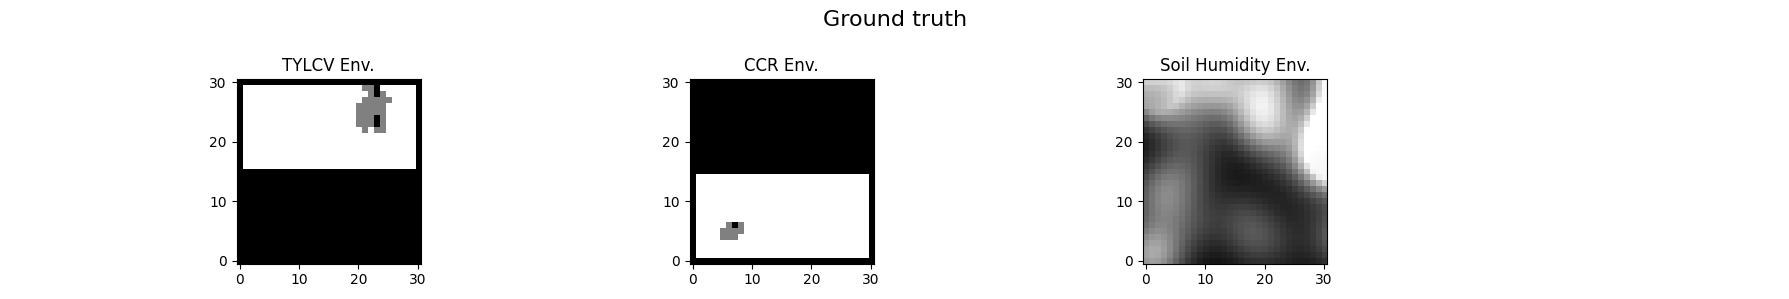

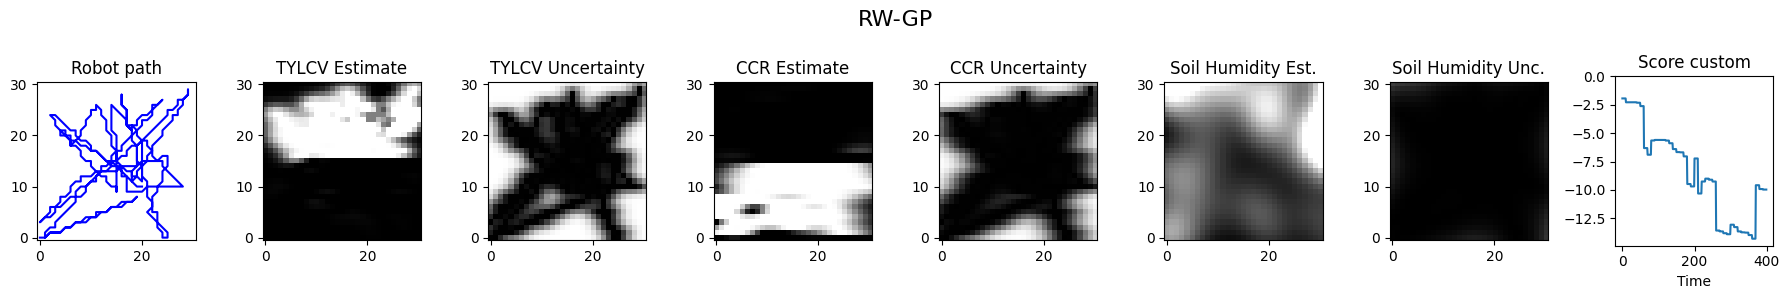

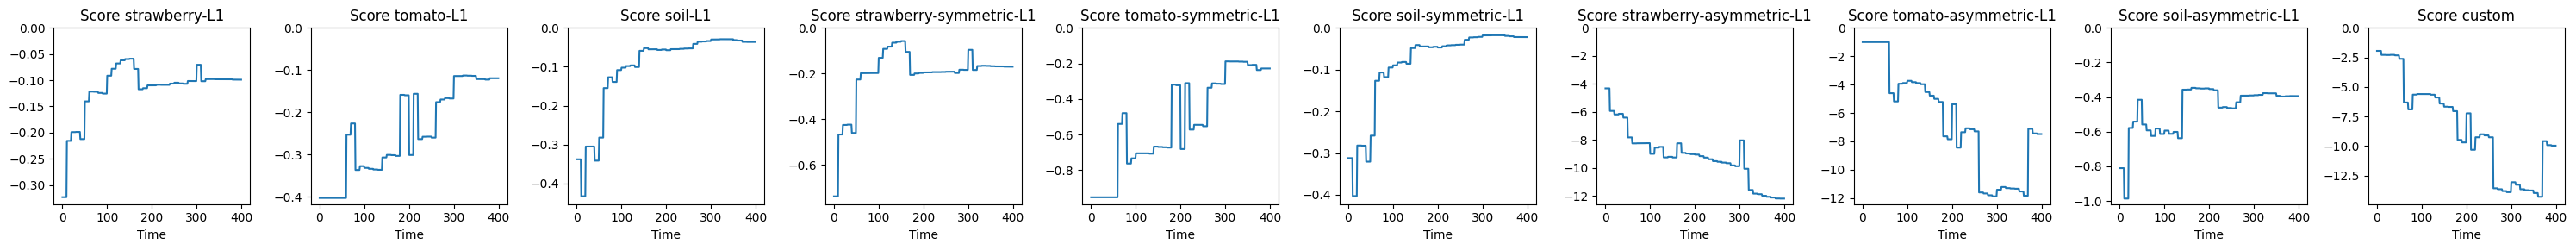

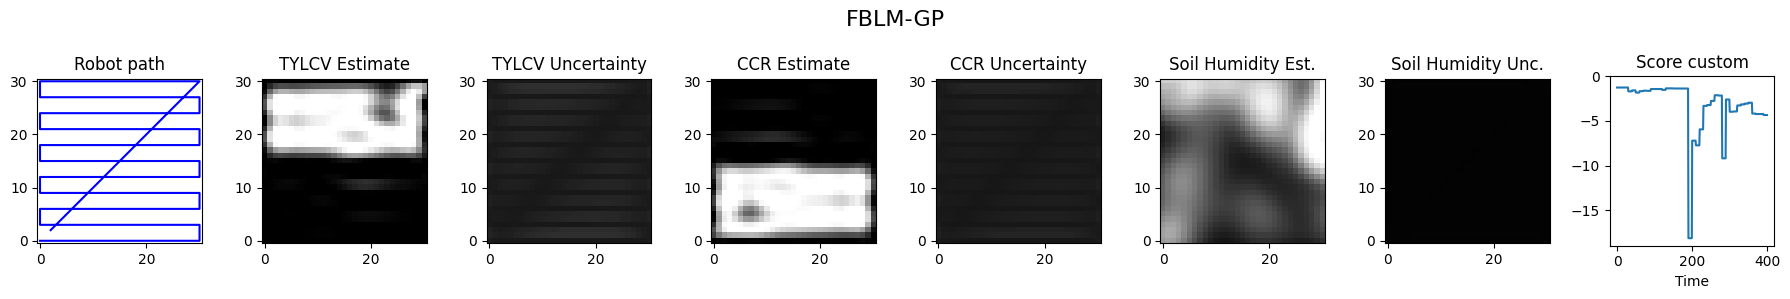

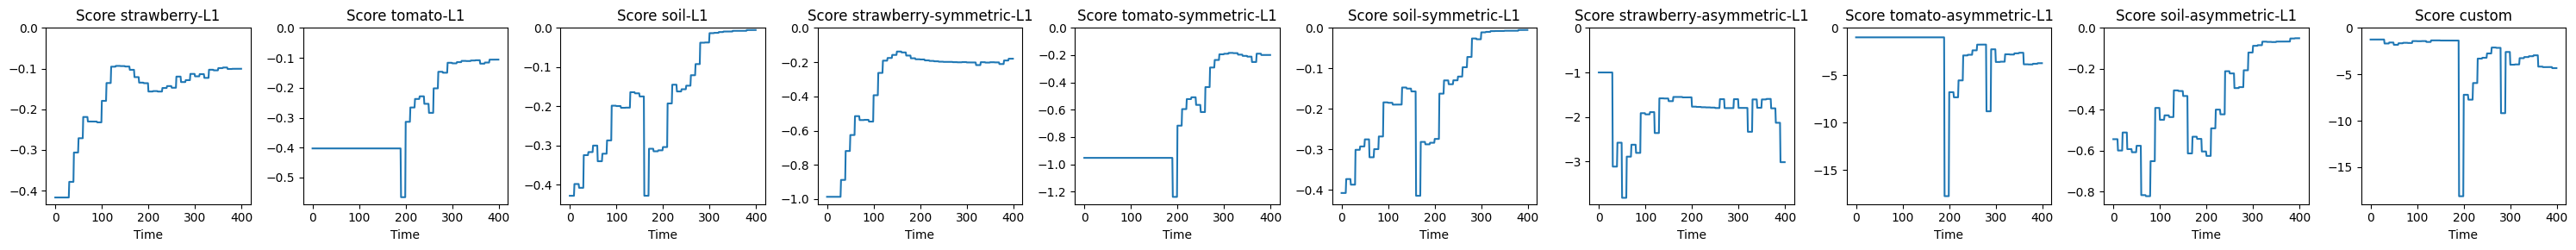

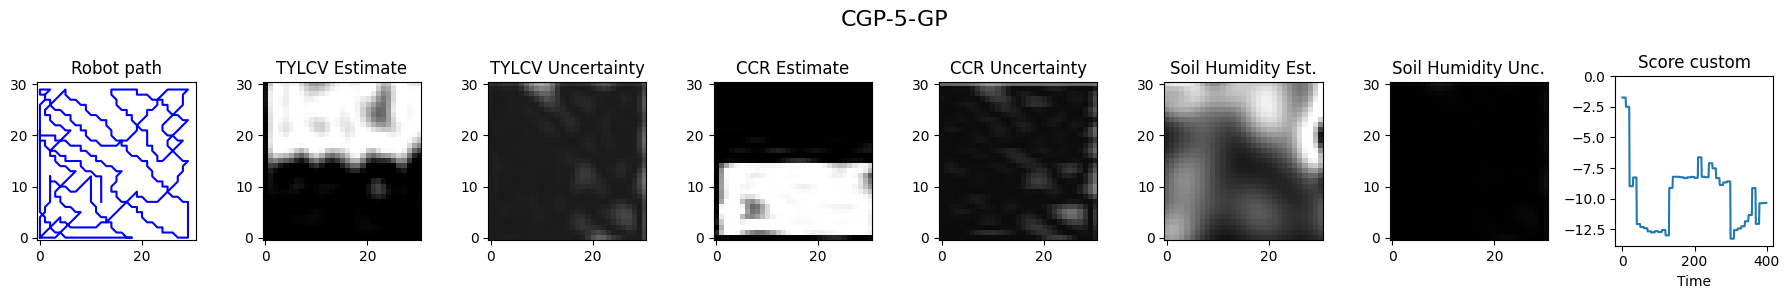

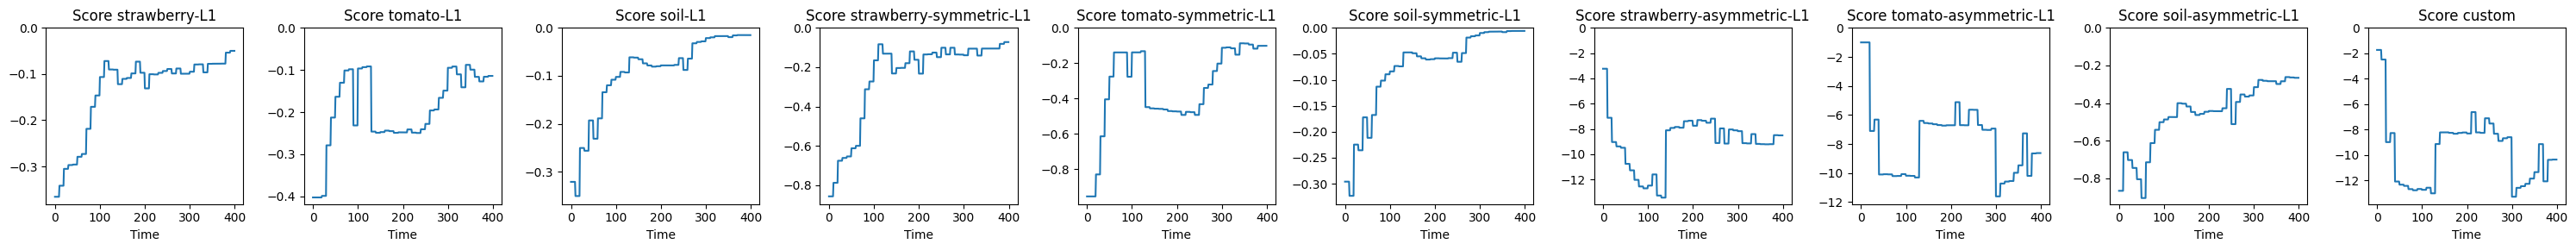

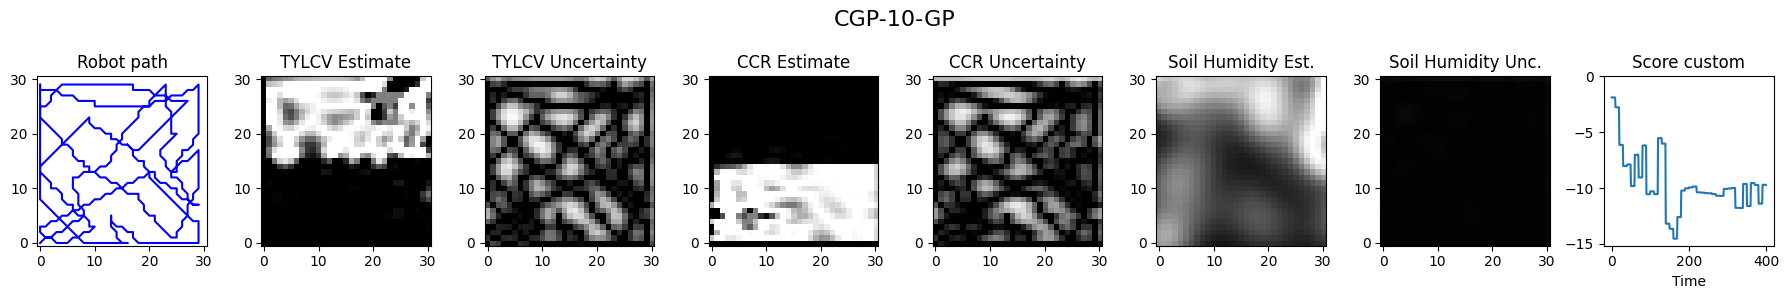

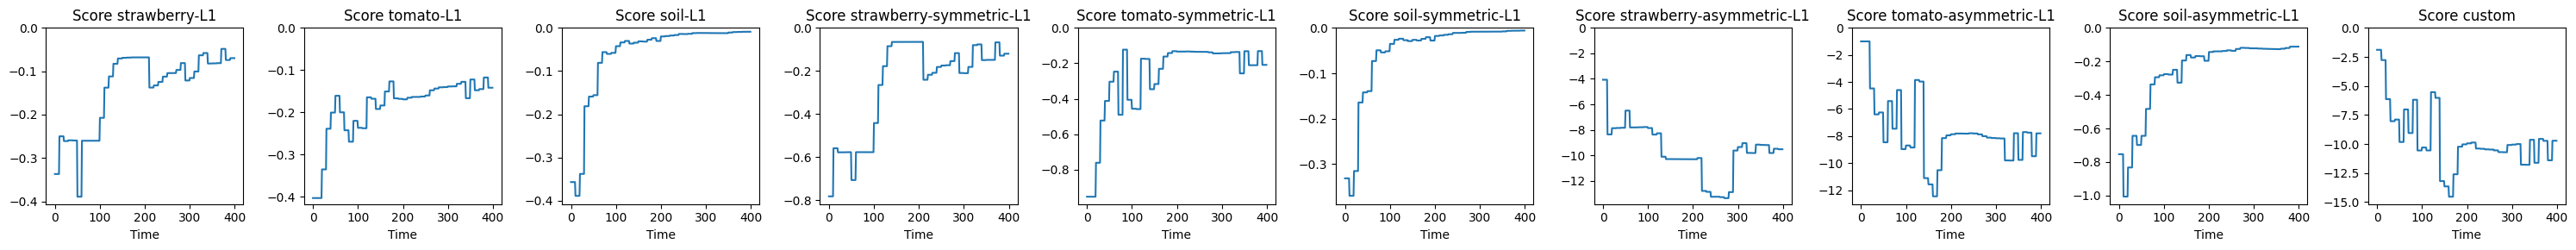

In [5]:
# cleaning up the warnings from the GP estimator
# logging.getLogger().setLevel(logging.ERROR)
warnings.simplefilter("ignore")
#warnings.filterwarnings(warnings.Warning, "ignore")

compare_path_planners()

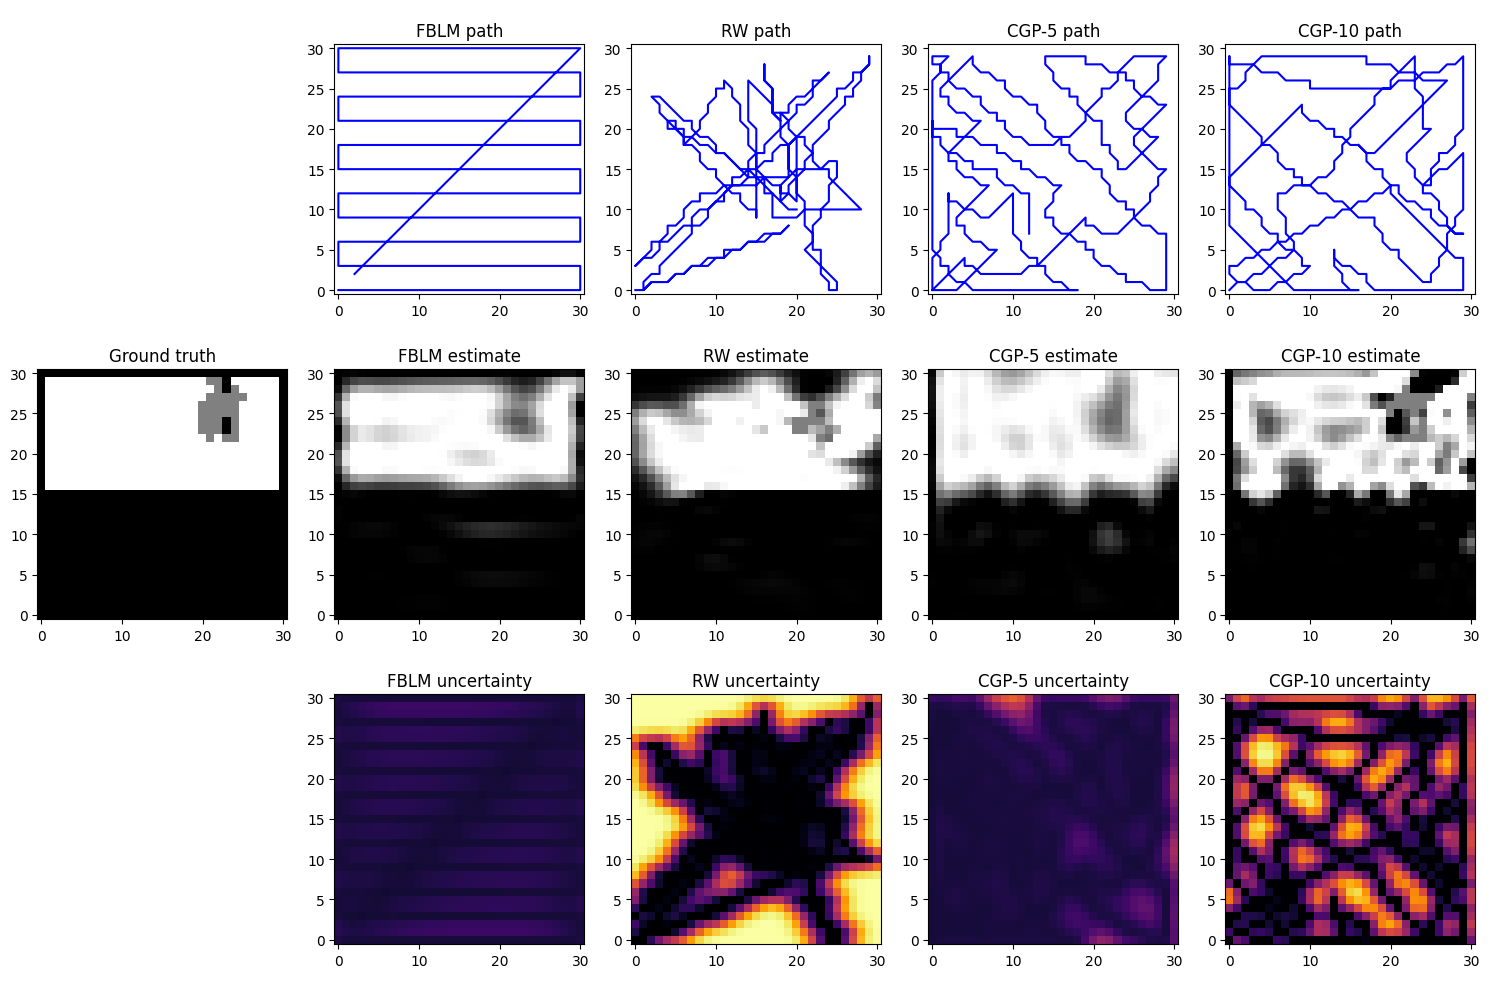

In [6]:
# create a custom figure for the paper
# gather all the results. As I am reading them in, generate the graphs.
allresults = []
for a in benchmark_dir.iterdir():
    if a.name.startswith("res_") and "picgen" not in a.name:
        with compress.open(a, "rb") as f:
            results = pickle.load(f)
            # allresults.append(results)
        if a.name.endswith("FBLM"):
            results_fblm = results
        elif a.name.endswith("RW"):
            results_rw = results
        elif a.name.endswith("CGP-5"):
            results_cgp5 = results
        elif a.name.endswith("CGP-10"):
            results_cgp10 = results

# fig, ((ax_empty1, ax_env_tylcv, ax_empty2), 
#      (ax1_path, ax1_im_tylcv, ax1_unc_tylcv),
#       (ax2_path, ax2_im_tylcv, ax2_unc_tylcv),
#       (ax3_path, ax3_im_tylcv, ax3_unc_tylcv),
#       (ax4_path, ax4_im_tylcv, ax4_unc_tylcv)) = plt.subplots(5, 3, figsize=(10,15))
fig, ((ax_empty1, ax1_path, ax2_path, ax3_path, ax4_path), 
      (ax_env_tylcv, ax1_im_tylcv, ax2_im_tylcv, ax3_im_tylcv, ax4_im_tylcv),
       (ax_empty2, ax1_unc_tylcv, ax2_unc_tylcv, ax3_unc_tylcv, ax4_unc_tylcv)) = plt.subplots(3, 5, figsize=(15,10))
ax_empty1.axis('off')
ax_empty2.axis('off')
graph_env_im(results_rw["wbfe"], results_rw["estimator-code"], ax_env_tylcv=ax_env_tylcv)
ax_env_tylcv.set_title("Ground truth")

uncmap = "inferno" # was "grey", "viridis"

# fixed budget lawnmower
empty = np.ones_like(results_fblm["wbfe"].tylcv.value.T)
image_env_tylcv = ax1_path.imshow(empty, vmin=0, vmax=1, origin="lower", cmap="gray")    
add_robot_path(results_fblm, ax1_path, draw_robot = False)
graph_env_im(results_fblm["wbfe"], results_fblm["estimator-code"], ax_im_tylcv=ax1_im_tylcv)
graph_env_im(results_fblm["wbfe"], results_fblm["estimator-code"], ax_unc_tylcv = ax1_unc_tylcv, cmap=uncmap)
ax1_path.set_title("FBLM path")
ax1_im_tylcv.set_title("FBLM estimate")
ax1_unc_tylcv.set_title("FBLM uncertainty")

# random waypoint
empty = np.ones_like(results_rw["wbfe"].tylcv.value.T)
image_env_tylcv = ax2_path.imshow(empty, vmin=0, vmax=1, origin="lower", cmap="gray")    
add_robot_path(results, ax2_path, draw_robot = False)
graph_env_im(results_rw["wbfe"], results_rw["estimator-code"], ax_im_tylcv=ax2_im_tylcv)
graph_env_im(results_rw["wbfe"], results_rw["estimator-code"], ax_unc_tylcv = ax2_unc_tylcv, cmap=uncmap)
ax2_path.set_title("RW path")
ax2_im_tylcv.set_title("RW estimate")
ax2_unc_tylcv.set_title("RW uncertainty")

# confidence-guided path planning span = 5
empty = np.ones_like(results_cgp5["wbfe"].tylcv.value.T)
image_env_tylcv = ax3_path.imshow(empty, vmin=0, vmax=1, origin="lower", cmap="gray")
add_robot_path(results_cgp5, ax3_path, draw_robot = False)
graph_env_im(results_cgp5["wbfe"], results_cgp5["estimator-code"], ax_im_tylcv=ax3_im_tylcv) 
graph_env_im(results_cgp5["wbfe"], results_cgp5["estimator-code"], ax_unc_tylcv = ax3_unc_tylcv, cmap=uncmap) 
ax3_path.set_title("CGP-5 path")
ax3_im_tylcv.set_title("CGP-5 estimate")
ax3_unc_tylcv.set_title("CGP-5 uncertainty")

# confidence-guided path planning span = 10
empty = np.ones_like(results_cgp10["wbfe"].tylcv.value.T)
image_env_tylcv = ax4_path.imshow(empty, vmin=0, vmax=1, origin="lower", cmap="gray")    
add_robot_path(results_cgp10, ax4_path, draw_robot = False)
graph_env_im(results_cgp10["wbfe"], results_cgp10["estimator-code"], ax_im_tylcv=ax4_im_tylcv)
graph_env_im(results_cgp10["wbfe"], results_cgp10["estimator-code"], ax_unc_tylcv = ax4_unc_tylcv, cmap=uncmap)
ax4_path.set_title("CGP-10 path")
ax4_im_tylcv.set_title("CGP-10 estimate")
ax4_unc_tylcv.set_title("CGP-10 uncertainty")

# 
plt.tight_layout()
plt.savefig(pathlib.Path(results["results-basedir"], "paper_results.pdf"))

import matplotlib.colors as colors
unc = results_fblm["estimator-code"].im_tylcv.uncertainty
fig, ax = plt.subplots(1, 1, figsize=(5,5))
# image_unc_tylcv = ax.imshow(unc.T, norm=colors.LogNorm(vmin=0, vmax=1), origin="lower", cmap="plasma")
image_unc_tylcv = ax.imshow(unc.T, norm=colors.Normalize(vmin=0, vmax=1), origin="lower", cmap="viridis")

label = "TYLCV Uncertainty"
#evalstring = f"f'{title_string}'"
#ax.set_title(eval(evalstring))


In [7]:
from typing import List

# Exponential moving average used by Tensorboard
def smooth(scalars: List[float], weight: float) -> List[float]:  # Weight between 0 and 1
    last = scalars[0]  # First value in the plot (first timestep)
    smoothed = list()
    for point in scalars:
        smoothed_val = last * weight + (1 - weight) * point  # Calculate smoothed value
        smoothed.append(smoothed_val)                        # Save it
        last = smoothed_val                                  # Anchor the last smoothed value
        
    return smoothed


C:\Users\lboloni\Documents\HackingWork\__Temporary\2022-01-15-MREM_data\ConfidenceGuidedIPP\res_Miniberry-30_1M_CGP-10
C:\Users\lboloni\Documents\HackingWork\__Temporary\2022-01-15-MREM_data\ConfidenceGuidedIPP\res_Miniberry-30_1M_CGP-5
C:\Users\lboloni\Documents\HackingWork\__Temporary\2022-01-15-MREM_data\ConfidenceGuidedIPP\res_Miniberry-30_1M_FBLM
C:\Users\lboloni\Documents\HackingWork\__Temporary\2022-01-15-MREM_data\ConfidenceGuidedIPP\res_Miniberry-30_1M_RW


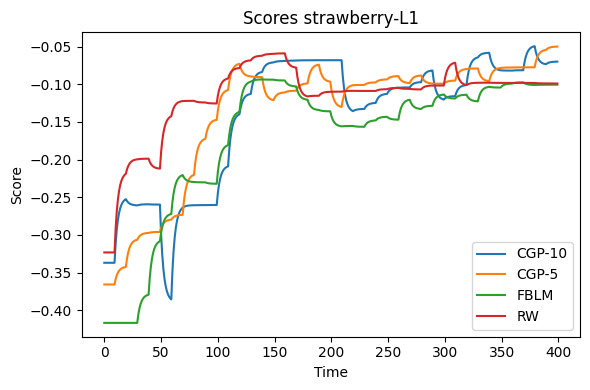

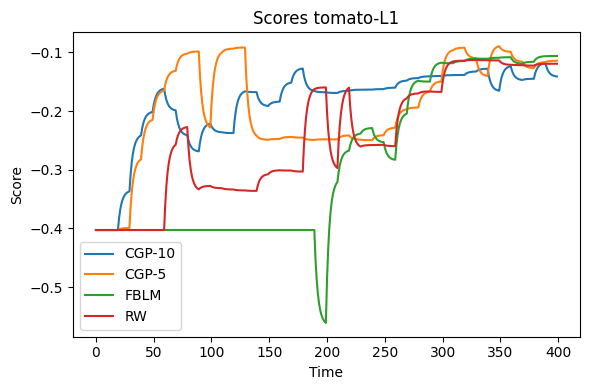

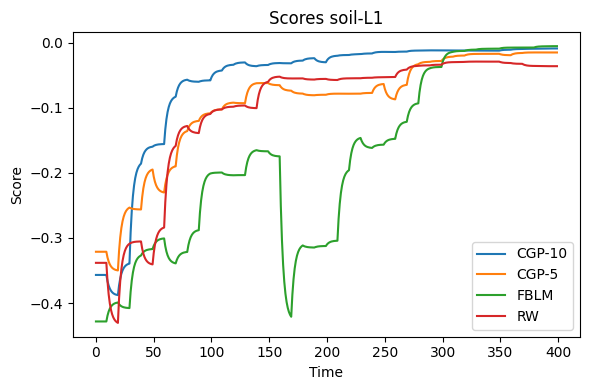

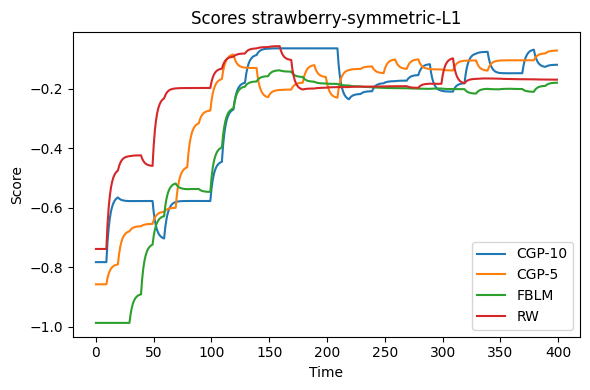

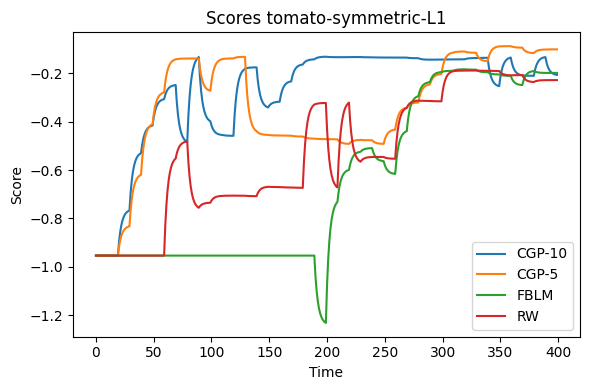

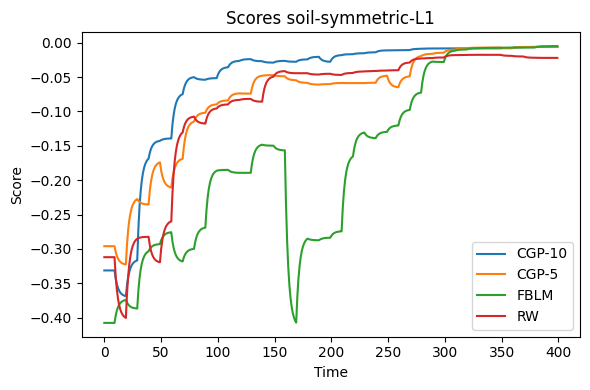

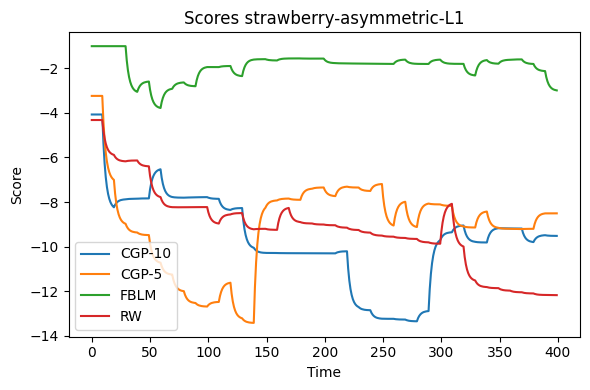

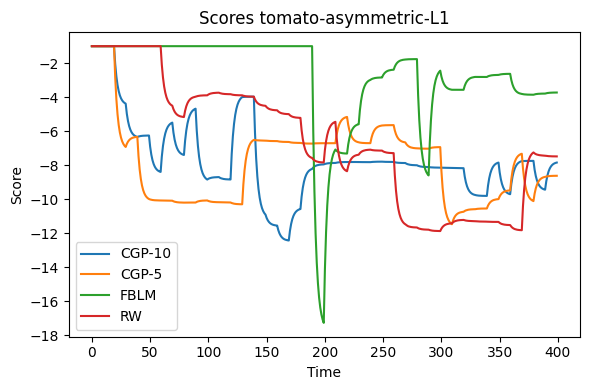

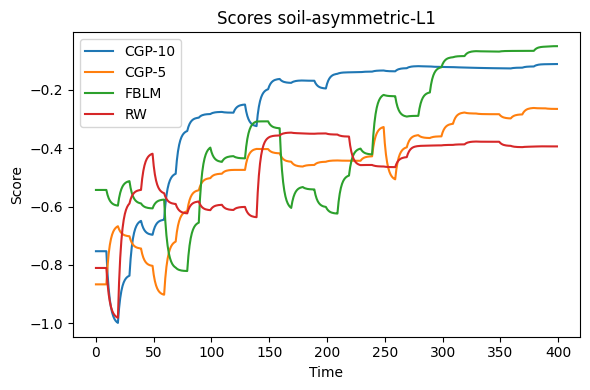

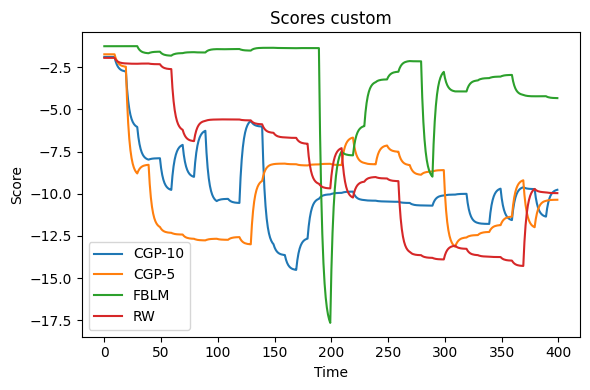

In [8]:

# gather all the results. As I am reading them in, generate the graphs.
allresults = []
for a in benchmark_dir.iterdir():
    if a.name.startswith("res_"):
        print(a)
        if "picgen" in str(a):
            continue
        with compress.open(a, "rb") as f:
            results = pickle.load(f)
            allresults.append(results)

for scorename in WBF_MultiScore.score_components():
    fig, ax_scores = plt.subplots(1, figsize=(6,4))
    for results in allresults:
        rawscore = results["scores"]
        scores = [a[scorename] for a in results["scores"]]
        # scores = smooth(scores, 0.99)
        scores = smooth(scores, 0.7)
        #ax_scores.plot(scores, label = f'{results["policy-name"]}+{results["estimator-name"]}')
        ax_scores.plot(scores, label = f'{results["policy-name"]}')
    # ax_scores.set_ylim(top=2)
    ax_scores.set_xlabel("Time")
    ax_scores.set_ylabel("Score")
    ax_scores.set_title(f"Scores {scorename}")
    ax_scores.legend()
    fig.tight_layout()
    plt.savefig(pathlib.Path(allresults[0]["results-basedir"], f"smoothed-score-in-time-{scorename}.pdf"))

## Plot the robot path and the intended robot path for the confidence guided IPP

In [9]:
def hook_CGP_pictures(results, figsize = (4,4)):
    """Hook for after day which generates the pictures of the graphs, for instance, for a movie"""

    wbfe, wbf = results["wbfe"], results["wbf"]
    wbfim = results["estimator-code"]
    path = results["results-path"]
    pnew = pathlib.Path(path.parent, "dir_" + path.name[4:])
    pnew.mkdir(exist_ok = True)
    results["picture-path"] = pnew
    logging.info(f"hook_create_pictures after {len(results['observations']):05d} observations")

    # tyclv-im-robot
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    graph_env_im(wbfe, wbfim, ax_unc_tylcv=ax, cmap="inferno") # was magma
    add_robot_path(results, ax, pathcolor="white", draw_it = True)
    robot = results["robot"]
    policy = robot.policy
    if policy.next_waypoint is not None:
        xs = [robot.x, policy.next_waypoint[0]]
        ys = [robot.y, policy.next_waypoint[1]]
        ax.add_line(lines.Line2D(xs, ys, color = "green"))
    picname = f"CGP-{len(results['observations']):05d}.jpg"
    plt.savefig(pathlib.Path(results["results-basedir"], pathlib.Path(pnew, picname)))
    plt.close(fig)

In [10]:
# run a small experiment, with the hook on

default_choices = {"geometry": "Miniberry-30", "action": "run", "scenario": "one-day-single-value", "visualize": 0,  "results-basedir": benchmark_dir}
default_choices["velocity"] = 1
default_choices["timesteps-per-day-override"] = 60 
default_choices["time-start-environment"] = 6
default_choices["im_resolution"] = 10
default_choices["hook-after-day"] = hook_CGP_pictures

geo = get_geometry(default_choices["geometry"])

# information greedy policy
estimator = WBF_IM_GaussianProcess(geo["width"], geo["height"])
policy = InformationGreedyPolicy(vel = geo["velocity"], low_point = [geo["xmin"], geo["ymin"]], high_point = [geo["xmax"], geo["ymax"]], estimator = estimator, span = 5)
policy.name = "CGP-5-picgen"

choices = copy.copy(default_choices)
choices["policy-code"] = policy
choices["policy-name"] = policy.name
choices["dryrun"] = False
choices["estimator-name"] = "GP"

choices["estimator-code"] = WBF_IM_GaussianProcess(geo["width"], geo["height"])                
#choices["estimator-code"] = WBF_IM_DiskEstimator(geo["width"], geo["height"])
choices["score-code"] = WBF_MultiScore()


# do a dryrun, to get the path to the cached values
results = action_run_oneday(choices)
# end_of_day_graphs(results, f"daily-summary-{results['policy-name']}-{results['estimator-name']}.pdf", ground_truth="est", score="custom")


NameError: name 'InformationGreedyPolicy' is not defined

In [ ]:
# only available in Unix
import time
# val = time.clock_gettime(time.CLOCK_MONOTONIC)
val = time.time_ns()
for i in range(10000):
    print(i)
# vale = time.clock_gettime(time.CLOCK_MONOTONIC)
vale = time.time_ns()
print(f"elapsed {vale - val} nanoseconds")